In [1]:
from ismn.interface import ISMN_Interface
from qa4sm_preprocessing.cgls_hr_ssm_swi.reader import S1CglsTs
import numpy as np
import ipywidgets as widgets
import os
import pandas as  pd
from ipywidgets import interact, interact_manual
import PIL
PIL.Image.MAX_IMAGE_PIXELS = None

path_ismn = "/shares/wpreimes/radar/Projects/QA4SM_HR/07_data/ISMN/ISMN_V20210131/"
path_cgls = "/shares/wpreimes/radar/Projects/QA4SM_HR/07_data/CGLS_SSM1km_V1.1_ts/"
path_lc = "/home/wpreimes/shares/users/backgrounds/CGLS_LandCover/PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif"

cgls_name = os.path.basename(os.path.normpath(path_cgls))

In [2]:
from ipywidgets import interact, Dropdown, Layout

ismn = ISMN_Interface(path_ismn,
                      network=['COSMOS', 'WEGENERNET', 'HOAL', 'SMOSMANIA', 'REMEDHUS'])

net, sta, sen = [], [], []
for network, station, sensor in ismn.collection.iter_sensors(
        variable='soil_moisture', depth=[0., 0.1]):
    net.append(network.name)
    sta.append(station.name)
    sen.append(sensor.name)

comps = pd.DataFrame(data={'network': net, 'station': sta, 'sensor': sen})

def load_inistu_data(net, stat, sens, only_good=True) -> (pd.DataFrame, pd.DataFrame):
    # load insitu data from a single sensor
    ts = ismn[net][stat][sens].read_data()
    meta = ismn[net][stat][sens].metadata.to_pd()
    
    if only_good:
        ts[ts['soil_moisture_flag'] != 'G'] = np.nan
    
    return ts, meta


Found existing ismn metadata in /shares/wpreimes/radar/Projects/QA4SM_HR/07_data/ISMN/ISMN_V20210131/python_metadata/ISMN_V20210131.csv.


In [3]:
cgls = S1CglsTs(path_cgls, parameter='ssm')

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from IPython.display import clear_output
from pytesmo.scaling import scale

%matplotlib inline
    

def plot_ts(tss, ref_name='ISMN', method=None):
    
    def mean_std_scale_ignore_nan(tss, ref_name='ISMN'):
        
        def scale(src, ref):
            return ((src - np.nanmean(src)) / np.nanstd(src)) * np.nanstd(ref) + np.nanmean(ref)
        
        dat_cols = tss.columns[tss.columns != ref_name]
        tss_scaled = pd.concat([scale(tss[c], tss[ref_name]) for c in dat_cols], axis=1)
        
        return tss_scaled
    
    
    ts_ref = tss[[ref_name]]
    tss_scaled = mean_std_scale_ignore_nan(tss, ref_name=ref_name)
    
    tss_scaled = pd.DataFrame(index=tss_scaled.index,
                             data={'mean': tss_scaled.mean(axis=1),
                                   'std': tss_scaled.std(axis=1),
                                   'N': tss_scaled.count(axis=1)})
    
    fig, ax = plt.subplots(figsize=(12, 3.5))
    ax.fill_between(tss_scaled.index, tss_scaled['mean'] - tss_scaled['std'],
                    tss_scaled['mean'] + tss_scaled['std'],
                    alpha=0.2, color='cornflowerblue', label='SM $\sigma$')
    ax.plot(tss_scaled['mean'].dropna().index, tss_scaled['mean'].dropna(), 
            color='cornflowerblue', label='MEAN Scaled Sat SM [m3/m3]')
    ax.plot(ts_ref.index, ts_ref[ref_name], color='red', label=ref_name)
    ax.set_xlabel('')
    ax.set_ylabel('SM $[m^3/m^3]$')
    
    pmax = np.nanmax([np.nanmax(np.abs(tss_scaled['mean'] + tss_scaled['std']))])
    pmin = np.nanmin([np.nanmin(np.abs(tss_scaled['mean'] - tss_scaled['std']))])

    ax.set_ylim(pmin, pmax)
    ax.legend(loc='upper left')
    ax.xaxis.grid(True)

    fig.suptitle(f'Reference SM vs Satellite TS')
    
    corr_with_mean = ts_ref['ISMN'].corr(tss_scaled['mean'])
    rmsd_with_mean = ((ts_ref['ISMN'] - tss_scaled['mean']) ** 2).mean() ** .5
    textstr = f'$R={corr_with_mean:.2f}, RMSD={rmsd_with_mean:.3f}$'
    ax.text(0.7, 0.07, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
        
    return fig, ax

    

def plot_map(lons, lats, vals, station_lon=None, station_lat=None, background=None, metric='r', show_points=True):
    llc= [v for v in [ lons.min(), lats.min()]]
    urc= [v for v in [ lons.max(), lats.max()]]
    
    extent = [llc[0], urc[0], llc[1], urc[1]]
    
    if backgroundW.value.lower() == 'cgls landcover class':
        from io_utils.read.img_readers.cgls_lc import CglsLcImg
        lc_img = CglsLcImg.from_tiff(path_lc, extent=extent)
        request = None
    elif backgroundW.value.lower() == 'google earth (optical)':
        request = cimgt.GoogleTiles(style='satellite')
    elif backgroundW.value.lower() == 'google earth (terrain)':
        request = cimgt.GoogleTiles(style='terrain')
    else:
        raise NotImplementedError
    
    data_crs = ccrs.PlateCarree()
    
    fig, ax = plt.subplots(1,1, figsize=(8,8), subplot_kw={'projection': request.crs if request else data_crs})
    ax.set_extent(extent, crs=data_crs)

    if backgroundW.value.lower() == 'cgls landcover class':
        lc_img.plot(ax=ax, alpha=0.5 if show_points else 1)
    else:
        ax.add_image(request, 8, alpha=0.5)
    
    if metric.lower() == 'r':
        cmap = plt.get_cmap('RdYlBu')
        cblabel = 'R [-]'
        plt_kwargs = dict(vmin=-1, vmax=1)
    elif metric.lower() == 'bias':
        cmap = plt.get_cmap('Reds')
        cblabel = 'Bias $[m^3/m^3]$'
        plt_kwargs = dict(vmin=-1, vmax=1)
    else:
        raise NotImplementedError
        
    markersize=0.1

    ax.coastlines(resolution='110m', color='black', linewidth=0.25)
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='oldlace')
    ax.add_feature(cartopy.feature.STATES, linewidth=0.05, zorder=2)
    ax.add_feature(cartopy.feature.BORDERS, linewidth=0.1, zorder=2)

#    ax.gridlines(crs=data_crs, draw_labels=False,
#                linewidth=0.5, color='black', alpha=0.15, linestyle='--')
    if station_lon and station_lat:
        title_part2 = f"at Lon: {station_lon:.2f}, Lat: {station_lat:.2f}"
    else:
        title_part2 = ""
        
    ax.set_title(f"Pearson's R of {cgls_name} with ISMN station {title_part2}", fontsize=10)

    
    if show_points:
        im = ax.scatter(lons, lats, c=vals, cmap=cmap,
                   vmin=-1, vmax=1, edgecolors='black', linewidths=0.5, 
                   zorder=3, transform=data_crs)

        cb = fig.colorbar(im, orientation="horizontal", pad=0.01)
        cb.set_label(cblabel, fontsize=10, color='k')
    
    if (station_lon is not None) and (station_lat is not None):
        ax.scatter(station_lon, station_lat, 
                   s=100*(matplotlib.rcParams['lines.linewidth'] ** 2),
                   marker='^', c='black', zorder=4,
                   transform=data_crs)
    

    
    return fig, ax
    

def plot_circle_series(lons, lats, vals, stepsize=1000):
    fig, ax = plt.subplots(figsize=(12, 5))
    grid = cgls.grid
    pass

def process(b):
    net, stat, sens = netW.value, statW.value, sensW.value
    ismn_ts, ismn_ts_meta = load_inistu_data(net, stat, sens, only_good=True)
    station_lon, station_lat = ismn_ts_meta['longitude']['val'], ismn_ts_meta['latitude']['val']        
    sat_tss = cgls.read_area(station_lon, station_lat, radius=radiusW.value * 1000, area='circle', average=False)

    ismn_ts = ismn_ts.resample('D').mean()
    tss = sat_tss.resample('D').mean()

    tss['ISMN'] = ismn_ts

    corr = tss.corr()
    r_vals = corr.loc[corr.index != 'ISMN', 'ISMN']
    r_lons, r_lats = cgls.grid.gpi2lonlat(r_vals.index)
    

    with outputW:
        clear_output(wait=True)
        
        if checkboxesWs['map'].value:
            fig_map, ax_map = plot_map(r_lons, r_lats, r_vals, 
                               station_lon=station_lon, station_lat=station_lat)
        else:
            fig_map = None
        
        if checkboxesWs['rad'].value:
            fig_circ, ax_circ = plot_circle_series(r_lons, r_lats, r_vals, stepsize=1000)
        else:
            fig_circ = None
        
        if checkboxesWs['ts'].value:
            fig_ts, ax_ts = plot_ts(tss, ref_name='ISMN', method='mean_std')
        else:
            fig_ts = None
        
        display(fig_map, fig_ts, fig_circ)





In [13]:
from ipywidgets import HBox, interactive, Layout

def ismn_select(net, stat, sens):
    statW.options = np.unique(comps.loc[comps['network'] == net, 'station'].values)
    sensW.options = np.unique(comps.loc[(comps['network'] == net) & 
                                        (comps['station'] == stat), 'sensor'].values)

netW = Dropdown(options = np.unique(comps['network'].values), description="Network:", value='HOAL')
statW = Dropdown(description="Station:")
sensW = Dropdown(description="Sensor:", layout=Layout(width='35%'))

radiusW = widgets.BoundedIntText(value=15, min=0, max=100,step=1, description='Radius [km]:', disabled=False)


ismnSelW = interactive(ismn_select, net=netW, stat=statW, sens=sensW)
ismnSelW.update()

buttonW = widgets.Button(description='Go!', disabled=False, button_style='info', tooltip='Process', icon='check')
outputW = widgets.Output()    

checkboxesWs = {short : widgets.Checkbox(value=True, description=descr, disabled=False, indent=False) 
                for short, descr in {'map': 'Plot Map', 'ts': 'Plot Mean Ts', 'rad': 'Plot Radius Series'}.items()}
backgroundW = Dropdown(options=['Google Earth (Optical)', 'Google Earth (Terrain)', 'CGLS Landcover Class'], 
                       value='CGLS Landcover Class', description='Background:', disabled=False)
    

display(HBox(ismnSelW.children[:-1], layout = Layout(flex_flow='row wrap')))
display(radiusW, backgroundW)
display(HBox(list(checkboxesWs.values())))
display(buttonW)
display(outputW)

buttonW.on_click(process)

BoundedIntText(value=15, description='Radius [km]:')

Dropdown(description='Background:', index=2, options=('Google Earth (Optical)', 'Google Earth (Terrain)', 'CGL…

Button(button_style='info', description='Go!', icon='check', style=ButtonStyle(), tooltip='Process')

Output()

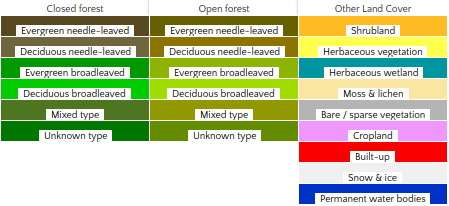

In [6]:
from IPython.display import Image
Image(filename='legend.png') 